# Use this notebook for experimentation

In [6]:
# Automatically re-import files when updated
%load_ext autoreload
%autoreload 2  
# Load packages
from models import *
from utils import *
from matplotlib import pyplot as plt
import time, json, pandas as pd, IPython

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Get data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
# Convert to tf dataset 
data_train = dataset_from_arrays(X_train, y_train)
data_test= dataset_from_arrays(X_test, y_test)

In [5]:
# Load models
with tf.keras.utils.custom_object_scope({
    'Inception': Inception,
    "downsampler": downsampler,
    "upsampler": upsampler
    }):
    decoder = tf.keras.models.load_model("decoder.keras")
    encoder = tf.keras.models.load_model("encoder.keras")
    classifier = tf.keras.models.load_model("classifier.keras")

True label: 5            
Predicted label on adversarial example: 6            
Predicted label on reconstructed image: 6


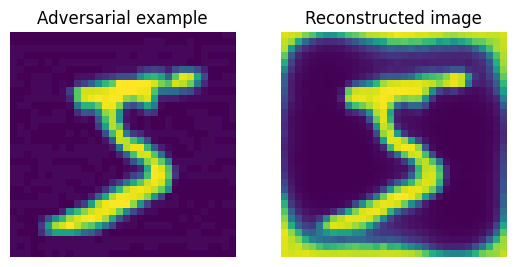

In [9]:
# Predict
imgs, labels = list(data_test.take(1))[0]
adv_imgs = fgsm(classifier, tf.keras.losses.CategoricalCrossentropy(), imgs, labels)
adv_predictions = classifier(adv_imgs)
z = encoder(adv_imgs)
reconstructed = decoder(z)
predictions = classifier(reconstructed)

# Plot
for (adv_img, rec, label, pred, adv_pred) in zip(adv_imgs, reconstructed, labels, predictions, adv_predictions):
    # Clear display
    IPython.display.clear_output()
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # Plot the original image
    ax1.imshow(adv_img)
    ax1.set_title("Adversarial example")
    ax1.axis('off')
    # Plot the reconstructed image
    ax2.imshow(rec)
    ax2.set_title("Reconstructed image")
    ax2.axis('off')
    # Add context
    print(f"True label: {tf.math.argmax(label).numpy()}\
            \nPredicted label on adversarial example: {tf.math.argmax(adv_pred).numpy()}\
            \nPredicted label on reconstructed image: {tf.math.argmax(pred).numpy()}")
    # Show for some time
    plt.show()
    time.sleep(2)

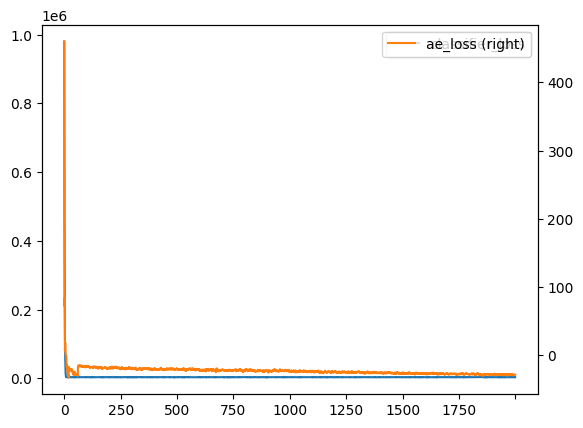

In [13]:
# Plot training progress
history = json.load(open("history.json", mode="r"))
history = pd.DataFrame.from_dict(history, orient="index")
history["classifier_loss"].plot();
history["ae_loss"].plot(secondary_y=True);
plt.legend();